In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from scipy.optimize import minimize
from timeit import default_timer as timer
from itertools import product, combinations
import sys

In [2]:
try:
    from sklearnex import patch_sklearn    
except ImportError:
    print("No Intel extension")
else:
    patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [16]:
ICM_ITERATIONS = 5
PDDP_flag = True
USE_MRF = True
use_Powell = False

In [4]:
def module_phase_to_complex(module, phase_difference, cross_phase = None):
    module_sqrt = np.sqrt(module)
    phase_difference_rads_1_2 = phase_difference.squeeze() * math.pi / 180 / 2
    cross_phase = cross_phase.squeeze()

    if cross_phase is None:
        real_image = np.zeros((module.shape[0], module.shape[1], 2))
        immaginary_image = np.zeros((module.shape[0], module.shape[1], 2))
    else:
        real_image = np.zeros((module.shape[0], module.shape[1], 3))
        immaginary_image = np.zeros((module.shape[0], module.shape[1], 3))

        real_image[:,:,2] = module_sqrt[:,:,2] * np.cos(cross_phase)
        immaginary_image[:,:,2] = module_sqrt[:,:,2] * np.sin(cross_phase)
            
    real_image[:,:,0] = module_sqrt[:,:,0] * np.cos(phase_difference_rads_1_2)
    immaginary_image[:,:,0] = module_sqrt[:,:,0] * np.sin(phase_difference_rads_1_2)

    real_image[:,:,1] = module_sqrt[:,:,1] * np.cos(phase_difference_rads_1_2)
    immaginary_image[:,:,1] = - module_sqrt[:,:,1] * np.sin(phase_difference_rads_1_2)

    return np.concatenate((np.expand_dims(real_image, axis=-1), np.expand_dims(immaginary_image, axis=-1)), axis=-1)


In [5]:
def module_kernel(gamma):
    def gaussian(X, Y):
        #not using modules but all values as different channels
        X_matrix = np.reshape(X,(X.shape[0],1,-1))
        Y_matrix = np.reshape(Y,(1,Y.shape[0],-1))
        D = np.sum((X_matrix - Y_matrix) ** 2, axis=-1)

        return np.exp(- D * gamma)
    return gaussian

In [6]:
def module_kernel_mrf(gamma, lambda_):
    def gaussian(X, Y):
        #not using modules but all values as different channels
        X_matrix = np.reshape(X,(X.shape[0],1,-1))
        Y_matrix = np.reshape(Y,(1,Y.shape[0],-1))

        D = np.sum((X_matrix[:,:,:X_matrix.shape[2] - 2] - Y_matrix[:,:,:Y_matrix.shape[2] - 2]) ** 2, axis=-1)
        # return np.exp(- D * gamma) + lambda_ * X_matrix[:,:,X_matrix.shape[2] - 2] * Y_matrix[:,:,Y_matrix.shape[2] - 2]
        #instead of multiplying by lambda every time, I pre-multiply everything by lambda
        return np.exp(- D * gamma) + X_matrix[:,:,X_matrix.shape[2] - 2] * Y_matrix[:,:,Y_matrix.shape[2] - 2]
    return gaussian

In [7]:
def complex_kernel(gamma):
    def gaussian(X, Y):
        X_comp = np.array(X[:,:,0], dtype='complex128')
        X_comp.imag = X[:,:,1]
        Y_comp = np.array(Y[:,:,0], dtype='complex128')
        Y_comp.imag = Y[:,:,1]
        X_comp_matrix = np.reshape(X_comp,(X_comp.shape[0],1,-1))
        Y_comp_matrix = np.reshape(Y_comp,(1,Y_comp.shape[0],-1))
        D_c = np.sum((X_comp_matrix - Y_comp_matrix.conj()) ** 2, axis=-1)
        res = np.exp(- D_c * gamma)

        return res.real
    return gaussian

In [8]:
def complex_kernel_mrf(gamma, lambda_):
    def gaussian(X, Y):
        X_comp = np.array(X[:,:,0], dtype='complex128')
        X_comp.imag = X[:,:,1]
        Y_comp = np.array(Y[:,:,0], dtype='complex128')
        Y_comp.imag = Y[:,:,1]
        X_comp_matrix = np.reshape(X_comp,(X_comp.shape[0],1,-1))
        Y_comp_matrix = np.reshape(Y_comp,(1,Y_comp.shape[0],-1))
        D_c = np.sum((X_comp_matrix[:,:,:X_comp_matrix.shape[2] - 1] - Y_comp_matrix[:,:,:Y_comp_matrix.shape[2] - 1].conj()) ** 2, axis=-1)
        res = np.exp(- D_c * gamma) + X_comp_matrix[:,:,X_comp_matrix.shape[2] - 1] * Y_comp_matrix[:,:,Y_comp_matrix.shape[2] - 1]
        #instead of multiplying by lambda every time, I pre-multiply everything by lambda

        return res.real
    return gaussian

In [9]:
def svm_optimization_problem(x, *args): 
    # args[0]: complex_flatten_filtered
    # args[1]: train_map_flatten_filtered
    # C = math.exp(x[0])
    # gamma = 0.5 * math.exp(-x[1])
    C = x[0]
    gamma = x[1]
    clf = svm.SVC(kernel=complex_kernel(gamma=gamma), C=C)
    clf.fit(X=args[0][0], y=args[0][1])
    # CHANGE score to nuSVM upperbound
    score = clf.score(X=args[0][0], y=args[0][1])
    return 1/score

In [10]:
def nusvm_optimization_problem(x, *args): 
    # args[0]: complex_flatten_filtered
    # args[1]: train_map_flatten_filtered
    # C = math.exp(x[0])
    # gamma = 0.5 * math.exp(-x[1])
    nu = x[0]
    gamma = x[1]
    clf = svm.NuSVC(kernel=complex_kernel(gamma=gamma), nu=nu)
    clf.fit(X=args[0][0], y=args[0][1])
    # CHANGE score to nuSVM upperbound
    score = clf.score(X=args[0][0], y=args[0][1])
    return 1/score

In [11]:
def EpsilonCompute(predicted_image, i, j):
    
    epsilon = 0
    count = 0
    center_class = predicted_image[i,j]
    for coordinate in product(list(range(-1,2)),repeat=2):
        new_i = i + coordinate[0]
        new_j = j + coordinate[1]
        if (new_i >= 0) and (new_i < predicted_image.shape[0]) and (new_j >= 0) and (new_j < predicted_image.shape[1]):
            count +=1
            if predicted_image[new_i,new_j] == center_class:
                epsilon +=1
            else:
                epsilon -=1

    # The center point should be disregarded
    epsilon -= 1
    count -=1
    return epsilon/count

In [12]:
def EpsilonPredictCompute(clf, input_image, i, j):
    
    epsilon = 0
    count = 0
    center_class = clf.predict(input_image[i,j])
    for coordinate in product(list(range(-1,2)),repeat=2):
        new_i = i + coordinate[0]
        new_j = j + coordinate[1]
        if (new_i >= 0) and (new_i < input_image.shape[0]) and (new_j >= 0) and (new_j < input_image.shape[1]):
            count +=1
            if clf.predict(input_image[new_i,new_j]) == center_class:
                epsilon +=1
            else:
                epsilon -=1

    # The center point should be disregarded
    epsilon -= 1
    count -=1
    return epsilon/count

In [13]:
complex_image = np.load('Input/complex_image.npy')
train_map = np.load('Input/train_map.npy')
n_classes = train_map.max()
complex_flatten_filtered = np.load('Input/complex_flatten_filtered.npy')
complex_image_flatten = np.load('Input/complex_image_flatten.npy')
train_map_flatten = np.load('Input/train_map_flatten.npy')
train_map_flatten_filtered = np.load('Input/train_map_flatten_filtered.npy')

In [14]:
# Parameter tunning

if use_Powell:
    x0 = np.array((1,1))
    sol = minimize(
            svm_optimization_problem,
            x0=x0, 
            args=[complex_flatten_filtered, train_map_flatten_filtered],
            method="Powell",
            # bounds=((-4,3),(-1.4,1))
            bounds=((0.02,20),(0.02,1.8))
    )

    x = sol.x
    # C = math.exp(x[0])
    # gamma = 0.5 * math.exp(-x[1])
    C = x[0]
    gamma = x[1]
    print(f"C:{C}    gamma:{gamma}")
else:
    # C = 2.718
    # gamma = 0.35
    C = 6.440844467317145
    gamma = 1.7590907440038555

In [15]:
# Predict No MRF
if(not USE_MRF):
    clf = svm.SVC(kernel=complex_kernel(gamma=gamma), C=C)
    clf.fit(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    score = clf.score(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    print(f"score:{score}")
    # y_predicted = clf.predict(complex_flatten_filtered)
    # print(confusion_matrix(y_pred=y_predicted, y_true=train_map_flatten_filtered))

    clf = svm.SVC(kernel=module_kernel(gamma=0.35), C=2.718)
    clf.fit(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    score = clf.score(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    print(f"score:{score}")
    # y_predicted = clf.predict(complex_flatten_filtered)
    # print(confusion_matrix(y_pred=y_predicted, y_true=train_map_flatten_filtered))

In [17]:
print(C)
print(gamma)

6.440844467317145
1.7590907440038555


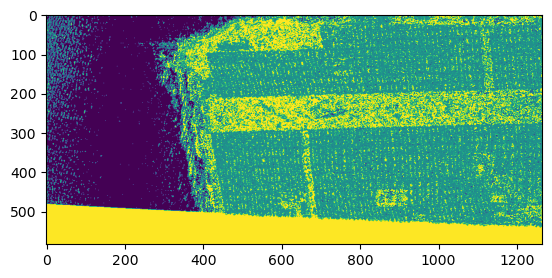

In [90]:
# Predict MRF

lambda_ = 1 #handpicked
partition = 25
# only because i use the real
gamma=0.35
C=2.718

clf = svm.SVC(kernel=module_kernel_mrf(gamma=gamma, lambda_=lambda_), C=C)
# clf = svm.SVC(kernel=complex_kernel_mrf(gamma=gamma, lambda_=lambda_), C=C)

# y_predicted = clf.fit_predict(X=complex_flatten_filtered, y=train_map_flatten_filtered)
spatial_image = np.zeros((complex_image.shape[0], complex_image.shape[1], complex_image.shape[2] + 1, complex_image.shape[3]))
spatial_image[:,:,:complex_image.shape[2],:] = complex_image

vote_map = np.zeros((train_map.shape[0],train_map.shape[1], n_classes))

classes_labels = [x+1 for x in range(n_classes)]
for pair in combinations(classes_labels,2):
    train_map_pair = np.zeros(train_map.shape)
    train_map_pair[train_map==pair[0]] = pair[0]
    train_map_pair[train_map==pair[1]] = pair[1]
    train_map_pair_flatten = np.reshape(train_map_pair,(-1))
    train_map_pair_flatten_filtered = train_map_pair_flatten[train_map_pair_flatten != 0]

    for iter in range(ICM_ITERATIONS):
        spatial_image_flatten = np.reshape(spatial_image, (-1,4,2))
        spatial_flatten_filtered = spatial_image_flatten[train_map_pair_flatten != 0]

        clf.fit(X=spatial_flatten_filtered, y=train_map_pair_flatten_filtered)

        y_predicted_flatten = np.zeros((train_map_pair_flatten.shape)) 
        for division in range(partition):
            y_predicted_flatten[
                y_predicted_flatten.size // partition * division : y_predicted_flatten.size // partition * (division + 1)
                ] = clf.predict(spatial_image_flatten[
                y_predicted_flatten.size // partition * division : y_predicted_flatten.size // partition * (division + 1)
                ]) 
        y_predicted_flatten[y_predicted_flatten.size // partition * partition:] = clf.predict(spatial_image_flatten[y_predicted_flatten.size // partition * partition:])
        y_predicted_image = np.reshape(y_predicted_flatten,(train_map.shape))

        if (iter<ICM_ITERATIONS - 1): #in the last run it is not necessary
            for i in range(spatial_image.shape[0]):
                for j in range(spatial_image.shape[1]):                    
                    spatial_image[i,j,3,0] = EpsilonCompute(y_predicted_image,i,j)
                    # if (iter==ICM_ITERATIONS - 1):
                    #     pass

                    
    vote_map[y_predicted_image.squeeze() == pair[0],pair[0] - 1] += 1
    vote_map[y_predicted_image.squeeze() == pair[1],pair[1] - 1] += 1


max_vote = np.argmax(vote_map, axis=2) + 1
plt.imshow(max_vote * 255. / max_vote.max())
plt.show()

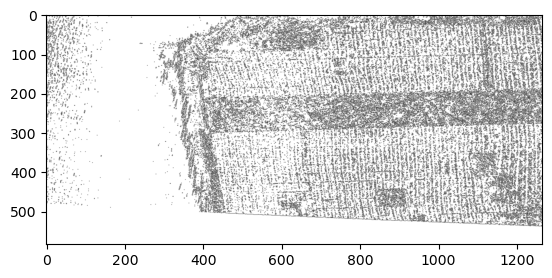

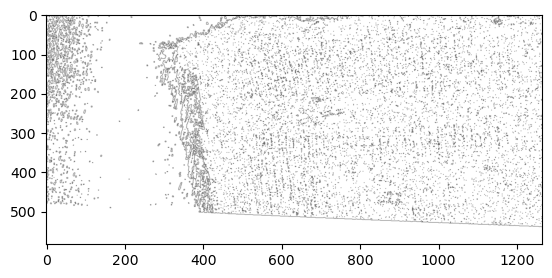

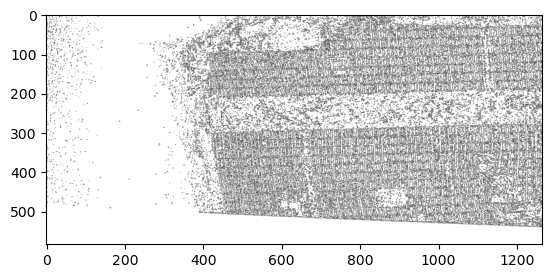

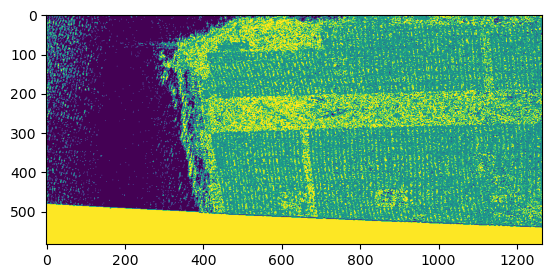

In [ ]:
# Predict

if (USE_MRF): # MRF

    lambda_ = 15 #handpicked

    # clf = svm.SVC(kernel=module_kernel_mrf(gamma=gamma, lambda_=lambda_), C=C)
    #only because i use the real
    # gamma=0.35
    # C=2.718
    # clf = svm.SVC(kernel=module_kernel_mrf(gamma=gamma, lambda_=lambda_), C=C)
    clf = svm.SVC(kernel=complex_kernel_mrf(gamma=gamma, lambda_=lambda_), C=C)

    # y_predicted = clf.fit_predict(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    spatial_image = np.zeros((complex_image.shape[0], complex_image.shape[1], complex_image.shape[2] + 1, complex_image.shape[3]))
    spatial_image[:,:,:complex_image.shape[2],:] = complex_image

    vote_map = np.zeros((train_map.shape[0],train_map.shape[1], n_classes))

    classes_labels = [x+1 for x in range(n_classes)]

    for pair in combinations(classes_labels,2):
        train_map_pair = np.zeros(train_map.shape)
        train_map_pair[train_map==pair[0]] = pair[0]
        train_map_pair[train_map==pair[1]] = pair[1]
        train_map_pair_flatten = np.reshape(train_map_pair,(-1))
        train_map_pair_flatten_filtered = train_map_pair_flatten[train_map_pair_flatten != 0]

        for iter in range(ICM_ITERATIONS):
            spatial_image_flatten = np.reshape(spatial_image, (-1,4,2))
            spatial_flatten_filtered = spatial_image_flatten[train_map_pair_flatten != 0]

            clf.fit(X = spatial_flatten_filtered, y=train_map_pair_flatten_filtered)

            try:
                y_predicted_flatten = clf.predict(spatial_image_flatten)
            except MemoryError as e:
                y_predicted_flatten = np.zeros((train_map_pair_flatten.shape)) 
                partition = 25
                for division in range(partition):
                    y_predicted_flatten[
                        y_predicted_flatten.size // partition * division : y_predicted_flatten.size // partition * (division + 1)
                        ] = clf.predict(spatial_image_flatten[
                        y_predicted_flatten.size // partition * division : y_predicted_flatten.size // partition * (division + 1)
                        ]) 
                        
                y_predicted_flatten[y_predicted_flatten.size // partition * partition:] = clf.predict(spatial_image_flatten[y_predicted_flatten.size // partition * partition:])
            y_predicted_image = np.reshape(y_predicted_flatten,(train_map.shape))

            if (iter<ICM_ITERATIONS - 1): #in the last run it is not necessary
                for i in range(spatial_image.shape[0]):
                    for j in range(spatial_image.shape[1]):                    
                        spatial_image[i,j,3,0] = EpsilonCompute(y_predicted_image,i,j)
                        if (iter==ICM_ITERATIONS - 1):
                            pass
                epsilon_image = spatial_image[:,:,3,0]
                plt.imshow((epsilon_image - epsilon_image.min()) / (epsilon_image.max() - epsilon_image.min()), cmap='gray')
                plt.show()

                        
        vote_map[y_predicted_image.squeeze() == pair[0],pair[0] - 1] += 1
        vote_map[y_predicted_image.squeeze() == pair[1],pair[1] - 1] += 1


    max_vote2 = np.argmax(vote_map, axis=2) + 1
    plt.imshow(max_vote2 * 255. / max_vote2.max())
    plt.show()
else: # No MRF
    clf = svm.SVC(kernel=complex_kernel(gamma=gamma), C=C)
    clf.fit(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    score = clf.score(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    print(f"score:{score}")
    # y_predicted = clf.predict(complex_flatten_filtered)
    # print(confusion_matrix(y_pred=y_predicted, y_true=train_map_flatten_filtered))

    clf = svm.SVC(kernel=module_kernel(gamma=0.35), C=2.718)
    clf.fit(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    score = clf.score(X=complex_flatten_filtered, y=train_map_flatten_filtered)
    print(f"score:{score}")
    # y_predicted = clf.predict(complex_flatten_filtered)
    # print(confusion_matrix(y_pred=y_predicted, y_true=train_map_flatten_filtered))

In [21]:
print(confusion_matrix(y_pred=max_vote[(train_map!=0).squeeze()], y_true=train_map_flatten_filtered))
print(classification_report(y_pred=max_vote[(train_map!=0).squeeze()], y_true=train_map_flatten_filtered))
# print(max_vote[(train_map!=0).squeeze()].shape)

[[1983    0   17]
 [  77 1419  504]
 [ 183  254 1296]]
              precision    recall  f1-score   support

           1       0.88      0.99      0.93      2000
           2       0.85      0.71      0.77      2000
           3       0.71      0.75      0.73      1733

    accuracy                           0.82      5733
   macro avg       0.82      0.82      0.81      5733
weighted avg       0.82      0.82      0.82      5733



In [18]:
def HoKashyap(matrix, max_iterations):
    rho = 1
    eps = 1e-4
    delta = eps * 2
    matrix_sharp = np.linalg.pinv(np.transpose(matrix) @ matrix) @ np.transpose(matrix)
    col = matrix.shape[1]
    Lambda = np.ones(col)
    b = matrix @ Lambda
    b[b<0] = 1

    deltas = np.zeros(max_iterations)
    for i in range(max_iterations):
        if delta < eps:
            break
        delta = 0
        
        Lambda_old = Lambda
        Lambda = matrix_sharp @ b
        err = matrix @ Lambda - b
        b[err>0] += rho * err[err>0]

        err_max = rho * err.max()
        if err_max > delta :
            delta = err_max

        dif_max = (np.abs(Lambda - Lambda_old)).max()
        if dif_max > delta:
            delta = dif_max
        deltas[i] = delta
    
    return Lambda

In [19]:
def SVM_MRF_HoKashyap(clf, spatial_image, train_map_pair_flatten):

    spatial_image_flatten = np.reshape(spatial_image, (-1,4,2))
    spatial_flatten_filtered = spatial_image_flatten[train_map_pair_flatten != 0]

    L = spatial_flatten_filtered.shape[0]

    E = np.zeros((L, 2))
    sumepsilon = 0
    for i, index in enumerate(clf.support_):
        index_in_spatial_image_flatten = np.where(train_map_pair_flatten != 0)[0][index]
        row = index_in_spatial_image_flatten // spatial_image.shape[1]
        column = index_in_spatial_image_flatten % spatial_image.shape[1]
        sumepsilon += clf.dual_coef_[0,i] * spatial_image[row,column,3,0]

    E[:,0] = np.abs(clf.decision_function(spatial_flatten_filtered))

    for i in range(L):
        index_in_spatial_image_flatten = np.where(train_map_pair_flatten != 0)[0][i]
        row = index_in_spatial_image_flatten // spatial_image.shape[1]
        column = index_in_spatial_image_flatten % spatial_image.shape[1]
        E[i,1] = sumepsilon * (clf.predict(np.reshape(spatial_image[row,column],(1,4,2))) * 2 - 3) * spatial_image[row,column,3,0]
    
    Lambda_vector = HoKashyap(E, max_iterations = 1000000)
    
    return Lambda_vector[1]

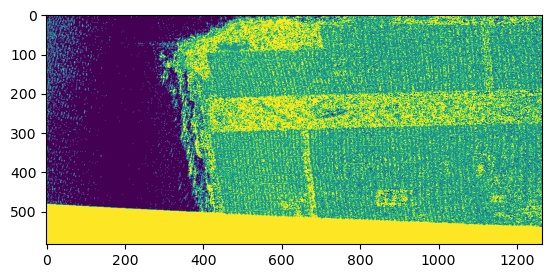

In [20]:
# Predict MRF with lambda calculation

lambda_ = 1 #handpicked
partition = 25
# only because i use the real
gamma=0.35
C=2.718

clf = svm.SVC(kernel=module_kernel_mrf(gamma=gamma, lambda_=lambda_), C=C)
# clf = svm.SVC(kernel=complex_kernel_mrf(gamma=gamma, lambda_=lambda_), C=C)

# y_predicted = clf.fit_predict(X=complex_flatten_filtered, y=train_map_flatten_filtered)
spatial_image = np.zeros((complex_image.shape[0], complex_image.shape[1], complex_image.shape[2] + 1, complex_image.shape[3]))
spatial_image[:,:,:complex_image.shape[2],:] = complex_image

vote_map = np.zeros((train_map.shape[0],train_map.shape[1], n_classes))

classes_labels = [x+1 for x in range(n_classes)]
for pair in combinations(classes_labels,2):
    train_map_pair = np.zeros(train_map.shape)
    train_map_pair[train_map==pair[0]] = pair[0]
    train_map_pair[train_map==pair[1]] = pair[1]
    train_map_pair_flatten = np.reshape(train_map_pair,(-1))
    train_map_pair_flatten_filtered = train_map_pair_flatten[train_map_pair_flatten != 0]

    for iter in range(ICM_ITERATIONS):
        spatial_image_flatten = np.reshape(spatial_image, (-1,4,2))
        spatial_flatten_filtered = spatial_image_flatten[train_map_pair_flatten != 0]

        clf.fit(X=spatial_flatten_filtered, y=train_map_pair_flatten_filtered)
        #ONLY for try
        # lambda_ = SVM_MRF_HoKashyap(clf, spatial_image, train_map_pair_flatten)

        y_predicted_flatten = np.zeros((train_map_pair_flatten.shape)) 
        for division in range(partition):
            y_predicted_flatten[
                y_predicted_flatten.size // partition * division : y_predicted_flatten.size // partition * (division + 1)
                ] = clf.predict(spatial_image_flatten[
                y_predicted_flatten.size // partition * division : y_predicted_flatten.size // partition * (division + 1)
                ]) 
        y_predicted_flatten[y_predicted_flatten.size // partition * partition:] = clf.predict(spatial_image_flatten[y_predicted_flatten.size // partition * partition:])
        y_predicted_image = np.reshape(y_predicted_flatten,(train_map.shape))

        if (iter<ICM_ITERATIONS - 1): #in the last run it is not necessary
            for i in range(spatial_image.shape[0]):
                for j in range(spatial_image.shape[1]):                    
                    spatial_image[i,j,3,0] = EpsilonCompute(y_predicted_image,i,j)

        if (iter == 0):
            #calculate lambda_
            lambda_ = SVM_MRF_HoKashyap(clf, spatial_image, train_map_pair_flatten)
        
        spatial_image[:,:,3,0] *= lambda_ # or sqrt(lambda_)?
                    
    vote_map[y_predicted_image.squeeze() == pair[0],pair[0] - 1] += 1
    vote_map[y_predicted_image.squeeze() == pair[1],pair[1] - 1] += 1

max_vote = np.argmax(vote_map, axis=2) + 1
plt.imshow(max_vote * 255. / max_vote.max())
plt.show()